# Exercise IV: Logistic Regression

> In statistics, the logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one. [*Wikipedia*](https://en.wikipedia.org/wiki/Logistic_regression)

In this exercise we will reproduce the bank defaults example used in chapter IV of the ISLR, as adapted from the [ISLR-python](https://github.com/JWarmenhoven/ISLR-python) repository.

## Setup

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import pandas as pd

URL = "https://github.com/JWarmenhoven/ISLR-python/raw/master/Notebooks/Data/Default.xlsx"
df = pd.read_excel(URL, index_col=0, true_values=["Yes"], false_values=["No"])

In [4]:
def color_booleans(value: bool) -> str:
    color = "green" if value else "red"
    return f"color: {color}"

BOOLEAN_COLUMNS = ["default", "student"]

df.sample(15).style.text_gradient(cmap="Blues").applymap(color_booleans, subset=BOOLEAN_COLUMNS)

,default,student,balance,income
965,False,False,0.000000,34305.918682
8655,False,True,17.609578,13739.754603
3649,False,False,370.033288,44507.211314
8672,False,False,761.187659,54681.828390
2605,True,False,1789.093391,48331.126858
7887,False,True,618.119217,24698.827238
1027,False,False,96.641839,44556.219419
3389,False,False,527.983482,39950.958521
8522,False,False,887.201436,41641.453572
1616,False,False,866.174669,41365.456380


### Feature Scaling

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler

numeric_features = df.select_dtypes(np.float)
scaler = StandardScaler()
df.loc[:, numeric_features.columns] = scaler.fit_transform(df.loc[:, numeric_features.columns])

## Raw inspection

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  bool   
 1   student  10000 non-null  bool   
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: bool(2), float64(2)
memory usage: 253.9 KB


In [7]:
pd.set_option('float_format', '{:g}'.format)
df.describe()

,balance,income
count,10000,10000
mean,-1.25056e-16,-1.93623e-16
std,1.00005,1.00005
min,-1.72708,-2.45539
25%,-0.731136,-0.913058
50%,-0.0242674,0.0776593
75%,0.684184,0.771653
max,3.76056,3.0022


### Scatter plot

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fix, ax = plt.subplots(figsize=(15, 12))
_ = sns.scatterplot(x="balance",
                    y="income",
                    hue="default",
                    style="student",
                    size="default",
                    sizes={
                        True: 100,
                        False: 40
                    },
                    alpha=0.6,
                    ax=ax,
                    data=df)

### Violin plot

In [9]:
# Create a new figure with two horizontal subplots 
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot balance
sns.violinplot(x="student", y="balance", hue="default", split=True, legend=False, ax=ax[0], data=df)
ax[0].get_legend().remove()
ax[0].set_xlabel('')

# Plot income
sns.violinplot(x="student", y="income", hue="default", split=True, ax=ax[1], data=df)
ax[1].set_xlabel('')

# Add common label
_ = fig.text(0.5, 0.05, "student", ha='center')

## Train/Test Split

In [33]:
from sklearn.model_selection import train_test_split 

FEATURE_NAMES = ["balance", "income", "student"]
TARGET_NAME = "default"
X = df[FEATURE_NAMES]
y = df[TARGET_NAME].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0,
                                                    test_size=0.2)

## Model Creation

### `sklearn`

In [34]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(random_state=0, penalty="none", solver="newton-cg")
_ = sk_model.fit(X_train, y_train)

### `statsmodels`

In [42]:
import statsmodels.api as sm

# statsmodels requires booelean values to be converted to integers.
df["student"] = df["student"].astype(int)
df["default"] = df["default"].astype(int)

# R-style model formulation.
sm_model = sm.Logit.from_formula('default ~ balance + income + student', data=df)

## Model Application

### `sklearn`

We can predict the **probability** estimates of each target class (in our case `True` or `False`) using the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class's [`predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) method:

In [43]:
default_probability = sk_model.predict_proba(X_test)

Or, we could directly return the predictions based on the maximal probabilities:

In [44]:
predictions = sk_model.predict(X_test)

# Manually returning the index of the maximal value
predictions_manual = default_probability.argmax(axis=1)

np.array_equal(predictions, predictions_manual)

NameError: name 'np' is not defined

### `statsmodels`

In [45]:
sm_estimation = sm_model.fit()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


## Model Evaluation

### `sklearn`

In [39]:
print(f"Intercept: {sk_model.intercept_}")
print(f"Coefficients: {sk_model.coef_}")

Intercept: [-10.55992039]
Coefficients: [[ 5.61993716e-03 -1.86000486e-06 -6.21154719e-01]]


#### Confusion Matrix

##### Calculation

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix_ = confusion_matrix(y_test, predictions)
print(confusion_matrix_)

[[1920    6]
 [  51   23]]


##### Visualization

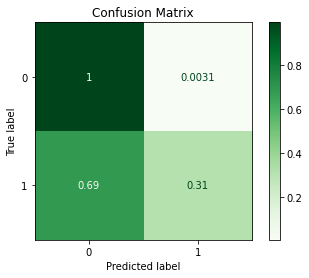

In [16]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(sk_model,
                             X_test,
                             y_test,
                             cmap=plt.cm.Greens,
                             normalize="true")
_ = disp.ax_.set_title(f"Confusion Matrix")

#### Classification Report

In [17]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1926
           1       0.79      0.31      0.45        74

    accuracy                           0.97      2000
   macro avg       0.88      0.65      0.72      2000
weighted avg       0.97      0.97      0.97      2000



![precision and recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)
*[Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)*

##### Precision

![precision](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [41]:
true_positive = confusion_matrix_[1, 1]
false_positive = confusion_matrix_[0, 1]

true_positive / (true_positive + false_positive)

0.7931034482758621

##### Recall (Sensitivity)

![recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [42]:
false_negative = confusion_matrix_[1, 0]

true_positive / (true_positive + false_negative)

0.3108108108108108

##### Specificity

![specificity](https://wikimedia.org/api/rest_v1/media/math/render/svg/8f2c867f0641e498ec8a59de63697a3a45d66b07)

In [43]:
true_negative = confusion_matrix_[0, 0]

true_negative / (true_negative + false_positive)

0.9968847352024922

##### Accuracy Score

In [33]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.9715

or:

In [37]:
true_predictions = confusion_matrix_[0, 0] + confusion_matrix_[1, 1]
true_predictions / len(X_test)

0.9715

### `statsmodels`

#### Confusion Matrix

In [18]:
prediction_table = sm_estimation.pred_table()
prediction_table

array([[9627.,   40.],
       [ 228.,  105.]])

In [19]:
row_sums = prediction_table.sum(axis=1, keepdims=True)
prediction_table / row_sums

array([[0.99586221, 0.00413779],
       [0.68468468, 0.31531532]])

#### Regression Report

In [20]:
sm_estimation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Wed, 25 Nov 2020   Pseudo R-squ.:                  0.4619
Time:                        09:36:17   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.9752      0.194    -30.849      0.000      -6.355      -5.596
balance        2.7747      0.112     24.737      0.000       2.555       2.995
income         0.0405      0.109      0.370      0.712      -0.174       0.255
student       -0.6468      0.236     -2.738      0.006      -1.110      -0.184
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""